# Machine Learning Approach to Estimating Photometric Redshifts

In this notebook I load and train a data set of ~8,000 galaxies in order to estimate photometric redshifts using a machine learning approach. Photometric redshifts for galaxies are typically estimated through spectral energy distribution (SED) fitting methods (see http://sedfitting.org/Welcome.html) and yield far poorer quality redshifts than those obtained from spectroscopy, however, they are often necessary for large surveys as obtaining spectroscopic redshifts can be time-consuming and computationally expensive. The goal of this notebook is to explore how to we can improve photometric redshift estimates over those yielded from current SED fitting methods implemented by codes such as EAZY-py (see [Brammer et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...686.1503B/abstract)).

All data in this notebook are taken from the NEWFIRM K-selected SHELA catalog (see [Stevans et al. 2020](https://ui.adsabs.harvard.edu/abs/2021arXiv210314690S/abstract)).

In [483]:
# Import all packages. We will use the XGBRegressor model to train the data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
# Load the training set

df = pd.read_csv('train.csv')

df.head()

,Unnamed: 0,ID,specz,zphot,u_flux,u_err,g_flux,g_err,r_flux,r_err,...,KUV_flux,KUV_err,K_flux,K_err,ch1_flux,ch1_err,ch2_flux,ch2_err,flags,ima_flags
0,0,20,0.256205,-1.000000,-0.001418,0.000821,-0.001997,0.001770,-0.003231,0.001197,...,0.121561,0.004110,0.075285,0.003976,0.003252,0.000646,0.006908,0.000906,0.0,0.0
1,1,211,0.172607,0.130125,0.034651,0.001142,0.067499,0.002198,0.097253,0.003159,...,0.152483,0.003921,0.189638,0.001914,0.119778,0.006480,0.089396,0.005202,0.0,0.0
2,2,242,0.079318,0.120774,0.116043,0.003775,0.284686,0.009201,0.422237,0.013636,...,0.877575,0.005355,0.890589,0.003378,0.357283,0.017104,0.243544,0.011885,0.0,0.0
3,3,326,0.185921,0.193527,0.021549,0.002031,0.042499,0.001376,0.073415,0.002400,...,0.160523,0.003876,0.178658,0.001520,0.107723,0.005346,0.090142,0.004713,2.0,0.0
4,4,462,0.119607,0.103759,0.033206,0.001113,0.137714,0.004451,0.350813,0.011316,...,-99.000000,-99.000000,1.683852,0.002232,0.935083,0.043477,0.693147,0.032371,0.0,0.0


In [484]:
# See target variable (specz) statistics:

df.specz.describe()

count    8319.000000
mean        0.285689
std         0.207407
min         0.003789
25%         0.095876
50%         0.243260
75%         0.451105
max         1.302800
Name: specz, dtype: float64

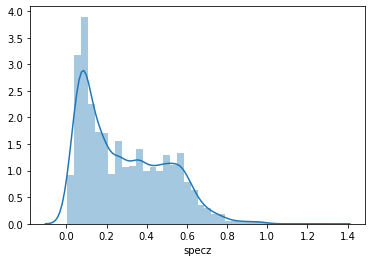

In [485]:
sns.distplot(df['specz']) # see distribution

(0, 1.3)

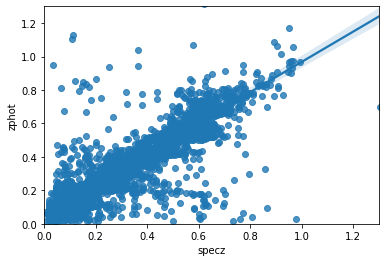

In [486]:
# First thing we will do is clean up the data so we only train on objects with flags = 0, and zphot > 0 

df.where((df['zphot'] > 0) & (df['flags'] == 0), inplace=True)
df.dropna(inplace=True)


# We now inspect how photometric redshifts from SED fitting compare to spectroscopic redshifts

sns.regplot(x='specz', y='zphot', data=df)
plt.xlim(0,1.3)
plt.ylim(0,1.3)


Looks okay for now. We will estimate the accuracy using the $\sigma_{\rm NMAD}$ metric from [Brammer et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...686.1503B/abstract) below.

In [487]:
def sigma_nmad(delta_z, specz):
    s = 1.48 * np.median(np.abs((delta_z - np.median(delta_z)) / 
                                (1. + np.median(specz) ) ))
    return s

delta_z = (df['zphot'] - df['specz'])

print("SIGMA_NMAD from SED fitting:", sigma_nmad(delta_z, df.specz))


SIGMA_NMAD from SED fitting: 0.03886758024830371


Now we will create new features to train the model, such as magnitudes, color, etc.

In [488]:
# Convert all fluxes to magnitudes, make color combinations which reveal something about shape of spectra

def flux_to_mag(flux):
    mag = -2.5 * np.log10(flux) + 16.4
    return mag

df['u_mag'] = flux_to_mag(df['u_flux'])
df['g_mag'] = flux_to_mag(df['g_flux'])
df['r_mag'] = flux_to_mag(df['r_flux'])
df['i_mag'] = flux_to_mag(df['i_flux'])
df['z_mag'] = flux_to_mag(df['z_flux'])
df['K_mag'] = flux_to_mag(df['K_flux'])
df['ch1_mag'] = flux_to_mag(df['ch1_flux'])
df['ch2_mag'] = flux_to_mag(df['ch2_flux'])

# Make several different color combinations

df['u_r'] = df['u_mag'] - df['r_mag']
df['g_i'] = df['g_mag'] - df['i_mag']
df['g_z'] = df['g_mag'] - df['z_mag']
df['g_K'] = df['g_mag'] - df['K_mag']
df['r_i'] = df['r_mag'] - df['i_mag']
df['r_K'] = df['r_mag'] - df['K_mag']
df['ch1_ch2'] = df['ch1_mag'] - df['ch2_mag']

# Define Signal-to-noise ratios

df['u_SNR'] = df['u_flux'] / df['u_err']
df['g_SNR'] = df['g_flux'] / df['g_err']
df['r_SNR'] = df['r_flux'] / df['r_err']
df['i_SNR'] = df['i_flux'] / df['i_err']
df['z_SNR'] = df['z_flux'] / df['z_err']
df['K_SNR'] = df['K_flux'] / df['K_err']
df['ch1_SNR'] = df['ch1_flux'] / df['ch1_err']
df['ch2_SNR'] = df['ch2_flux'] / df['ch2_err']

# Calculate total flux from new dataframe:

def ret_zero(flux):
    new_flux = flux.where(flux != -99, 0)
    return new_flux

wavelengths = [0.38566, 0.482, 0.6423, 0.78067, 0.91585, 1.25, 2.15, 2.17, 3.5569, 4.5]

c = 3.00e8

freq = [c / (wavelengths[x] * 1e-6) for x in range(len(wavelengths))]

df['total_flux'] = np.log10(ret_zero(df.u_flux) * freq[0] + ret_zero(df.g_flux) * freq[1] + ret_zero(df.r_flux) * freq[2] + \
                   ret_zero(df.i_flux) * freq[3] + ret_zero(df.z_flux) * freq[4] + ret_zero(df.K_flux) * freq[5] + \
                   ret_zero(df.ch1_flux) * freq[6] + ret_zero(df.ch2_flux) * freq[7])

df.fillna(0)

/Users/jonathanflorez/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Unnamed: 0,ID,specz,zphot,u_flux,u_err,g_flux,g_err,r_flux,r_err,...,ch1_ch2,u_SNR,g_SNR,r_SNR,i_SNR,z_SNR,K_SNR,ch1_SNR,ch2_SNR,total_flux
1,1.0,211.0,0.172607,0.130125,0.034651,0.001142,0.067499,0.002198,0.097253,0.003159,...,-0.317646,30.333418,30.712459,30.790534,30.763081,30.434176,99.076284,18.483823,17.186100,14.445809
2,2.0,242.0,0.079318,0.120774,0.116043,0.003775,0.284686,0.009201,0.422237,0.013636,...,-0.416089,30.743215,30.941438,30.965166,30.974332,30.937650,263.675627,20.889387,20.491019,15.070084
4,4.0,462.0,0.119607,0.103759,0.033206,0.001113,0.137714,0.004451,0.350813,0.011316,...,-0.325062,29.841182,30.942087,31.001149,31.007738,31.001541,754.447152,21.507651,21.412717,15.132726
5,5.0,647.0,0.644799,0.701364,0.001203,0.000110,0.003400,0.000175,0.014828,0.000509,...,-0.464690,10.896188,19.423791,29.121395,28.043192,28.361706,138.184377,20.026274,19.588607,14.205160
9,9.0,1780.0,0.459616,0.421326,0.003388,0.000401,0.016342,0.000860,0.078228,0.002650,...,-0.224277,8.448171,19.012940,29.520590,30.695950,30.477360,180.745523,20.651397,20.078604,14.502641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8308,8308.0,1241228.0,0.566096,0.783433,0.199379,0.006427,0.007839,0.001443,0.023677,0.001361,...,-0.502596,31.021035,5.431812,17.398926,19.684530,27.915912,49.610857,19.947306,19.259215,14.474764
8309,8309.0,1241421.0,0.081389,0.194602,-99.000000,-99.000000,0.106469,0.003492,0.173301,0.005652,...,-0.467969,1.000000,30.491821,30.663894,29.397021,30.587793,53.076575,19.696109,18.447478,14.636998
8315,8315.0,1243185.0,0.249715,0.243564,-99.000000,-99.000000,0.061946,0.002215,0.191074,0.006258,...,-0.177620,1.000000,27.965806,30.531243,30.310069,30.832854,159.903897,20.764594,20.531168,14.769719
8316,8316.0,1243836.0,0.059468,0.061734,-99.000000,-99.000000,0.081592,0.002679,0.060749,0.002112,...,0.188869,1.000000,30.454139,28.769772,24.959732,28.071606,23.142278,14.354052,14.421913,14.148164


In [489]:
# Select features to train model:

features = ['u_mag', 'g_mag', 'r_mag', 'i_mag', 'z_mag', 'K_mag', 'ch1_mag', 'ch2_mag', 
            'u_SNR', 'g_SNR', 'r_SNR', 'i_SNR', 'z_SNR', 'K_SNR', 'ch1_SNR', 'ch2_SNR',
            'u_r', 'g_i', 'g_z', 'g_K', 'r_i', 'r_K', 'ch1_ch2', 'total_flux']

# Make training and validation sets

X = df[features]
y = df.specz

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=0)
ind = y_val.index.values # obatin indices from validation data

In [490]:
# Define and train the model
model = XGBRegressor(n_estimators=500,learning_rate=0.05)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [491]:
# Make predictions on the model and compare to estimates from SED fitting

ML_z = model.predict(X_val)
print("Mean Absolute Error from ML: " + str(mean_absolute_error(ML_z, y_val)))
print("Mean Absolute Error from SED fitting: " + str(mean_absolute_error(df.zphot[ind], y_val)))

Mean Absolute Error from ML: 0.037576607415987354
Mean Absolute Error from SED fitting: 0.08345727902986856


(0, 1.1)

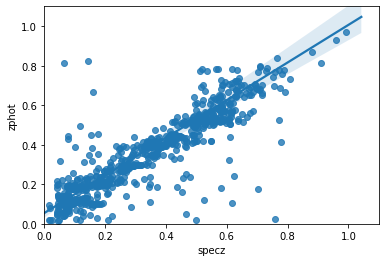

In [492]:
# Now compare z_phot vs. spec-z for the validation data. Remake regression plot from earlier:

sns.regplot(x=y_val, y=df.zphot[ind])
plt.xlim(0,1.1)
plt.ylim(0,1.1)


(0, 1.1)

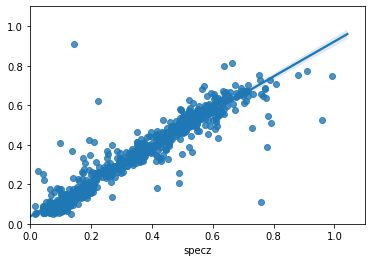

In [493]:
sns.regplot(x=y_val, y=ML_z)
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [494]:
dz1 = (ML_z - y_val)

print("sigma_NMAD from ML:", sigma_nmad(dz1, y_val))

dz2 = (df.zphot[ind] - y_val)

print("sigma_NMAD from SED fitting:", sigma_nmad(dz2, y_val))

sigma_NMAD from ML: 0.023837807872196682
sigma_NMAD from SED fitting: 0.041071931513985714


With machine learning, we were able to improve the $\sigma_{\rm NMAD}$ of the estimated photometric redshift from 0.041 (from SED fitting) to 0.024 on the validation set. The mean absolute error (MAE) of the predicted redshift from the true spectroscopic redshift improves from ~0.083 to ~0.038 - a significant improvement!